##네이버 영화리뷰 감성분석 도전하기  
텍스트 형식의 네이버 영화리뷰를 활용하여 그것이 긍정적인지 또는 부정적인지를 예측하는 모델을 구성하였고  
이는 RNN  구성방식 중 Many to One에 해당합니다.  
IMDB 데이터셋을 분석한 후 딥러닝 모델을 설계하고 훈련에
사용한 모델은 LSTM, 1-D CNN, GlovalAveragingPooling layer 총 세가지 입니다.  
총 50000개의 리뷰가 있고 긍정은 1, 부정은 0의 값입니다.    
train 데이터는 25000개이고 validation 데이터는 train의 40%인 87709개 입니다.  
첫번째는 네이버 영화 리뷰 텍스트를 활용했고 두번째는 word2Vec을 적용해서 성능을 개선하는 작업을 했습니다  
  
<b>전체 구성</b> 
1. 데이터 준비와 과정  
2. 데이터 로더 구성  
3. 모델구성 위한  
4. validation set 구성  
5. 모델구성(LSTM, 1-D CNN, GlovalAveragePooling layer)  
6. 모델 훈련  
7. 모델 평가  
8. 그래프 시각화    
9. Embedding layer 분석   
10. 한국어 Word2Vec 적용  
  
<목표>  
1. 3가지 이상 모델을 활용하여 Text Classification 구현  
2. 한국어 Word2Vec을 활용하여 성능향상 

In [1]:
#데이터 로더에 필요한 라이브러리
import os
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

%matplotlib inline
import matplotlib.pyplot as plt

import re
from konlpy.tag import Okt as okt
from tqdm import tqdm

import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

<b>1. 데이터 준비와 과정</b> 
train_data는 150,000개 
test_data는 50,000개  
columns는 'id', 'document', 'label'로 구성되어 있고 이 중에 'document'와 'label'만 사용 

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


<b>2. 데이터 로더 구성</b>  
● 데이터의 중복 제거  
● NaN 결측치 제거  
● 한국어 토크나이저로 토큰화  
● 불용어(Stopwords) 제거  
● 사전word_to_index 구성  
● 텍스트 스트링을 사전 인덱스 스트링으로 변환  
● X_train, y_train, X_test, y_test, word_to_index 리턴  
  
counter: counter 클래스, 데이터 개수 셀 때 사용
most_common(k): 데이터 개수가 많은 순으로 정렬된 배열을 리턴,  
                k인자로 넘기면 가장 개수가 많은 k개의 데이터를 얻을 수 있다.  

In [4]:
tokenizer = Mecab() #한국어 형태소 분석에 필요
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) #subset 중복 제거할 데이터
    train_data = train_data.dropna(how = 'any') #결측치 제거 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']: 
        temp_X = tokenizer.morphs(sentence) #문장 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 토큰화한 문장 중 stopwords 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist() #numpy array list로 반환 
    counter = Counter(words) 
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} #word _ndex 구성
        
    def wordlist_to_indexlist(wordlist):#텍스트 스트링을 사전 인덱스 스트링으로 변환 
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

print(words[:5]) => ['아', '더', '빙', '.', '.']  
print(counter[:10]) => [('.', 159415), ('영화', 57338), ('다', 54971), ('고', 47196), ('하', 44376), ('을', 29832), ('보', 25603), ('..', 22655), ('게', 22161), (',', 22047)]  
print(vocab[:10]) => ['', '', '', '', '.', '영화', '다', '고', '하', '을']
word_to_index 10개만 출력 
: 3
.: 4
영화: 5
다: 6
고: 7
하: 8
을: 9
보: 10
..: 11
게: 12

<b>3. Encode, decode 함수 정의</b>  
이미 위에서 word_to_index와 index_to_word를 구했기 때문에 아래 함수들이 필요 없지만 encode된 텍스트가 정상적으로 decode 되는지 확인하기 위해 get_decoded_sentence와 get_encoded_sentence 함수가 필요하다. 

In [5]:
#문장 1개, 딕셔너리를 인수로 주면 단어 인덱스 리스트 벡터로 변환, 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):  
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

#여러 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
#def get_encoded_sentences(sentences, word_to_index):
#    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

#encode된 문장을 decode하는 함수 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수 
#def get_decoded_sentences(encoded_sentences, index_to_word):
#    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
#encode된 텍스트가 정상적으로 decode되는지 확인
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [8]:
#확인해보니 word_to_index에 PAD, BOS, UNK, UNUSED가 없어 추가해줬다. 
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  
word_to_index["<UNUSED>"] = 3

<b>4. 모델구성 위한 준비</b>  
●max_len 설정  
●train dataset과 test dataset에 sequence padding 적용

In [9]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text] #토큰 길이
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens) #토큰 최대 길이
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

# 패딩 추가
# 마지막에 위치한 단어가 최종 state 값에 가장 많은 영향을 미치므로 padding을 pre로 지정.
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(146182, 41)
(146182,)
(49157, 41)


<b>5. Validation set 정의</b>

In [11]:
#학습 데이터의 40%를 validation set으로 사용
X_val = X_train[:58473]   
y_val = y_train[:58473]

partial_X_train = X_train[58473:]  
partial_y_train = y_train[58473:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(87709, 41)
(87709,)


<b>6. Model 설계</b>

In [12]:
vocab_size = 10000 #어휘 사전 크기
word_vector_dim = 16 #워드 벡터 차원의 수 

In [13]:
# LSTM
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm.add(keras.layers.LSTM(512))
lstm.add(keras.layers.Dense(512, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='relu'))

lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1083392   
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 1,506,561
Trainable params: 1,506,561
Non-trainable params: 0
_________________________________________________________________


In [14]:
# 1-D CNN
cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) 
cnn.add(keras.layers.Conv1D(32, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(32, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(16, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          3616      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [15]:
# one GlobalAveragePooling layer
gap = tf.keras.Sequential()
gap.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gap.add(keras.layers.GlobalAveragePooling1D())
gap.add(keras.layers.Dense(8, activation='relu'))
gap.add(keras.layers.Dense(1, activation='sigmoid')) #sigmoid relu로 변환

gap.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


<b>7.모델 학습</b>

In [16]:
#lstm 학습 
epochs = 10

lstm.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_lstm = lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
              

Epoch 1/10
172/172 [==============================] - 13s 58ms/step - loss: 7.6168 - accuracy: 0.4981 - val_loss: 7.6420 - val_accuracy: 0.4988
Epoch 2/10
172/172 [==============================] - 10s 56ms/step - loss: 7.6565 - accuracy: 0.4979 - val_loss: 7.6420 - val_accuracy: 0.4988
Epoch 3/10
172/172 [==============================] - 10s 56ms/step - loss: 7.6565 - accuracy: 0.4979 - val_loss: 7.6420 - val_accuracy: 0.4988
Epoch 4/10
172/172 [==============================] - 10s 56ms/step - loss: 7.6565 - accuracy: 0.4979 - val_loss: 7.6420 - val_accuracy: 0.4988
Epoch 5/10
172/172 [==============================] - 9s 55ms/step - loss: 7.6565 - accuracy: 0.4979 - val_loss: 7.6420 - val_accuracy: 0.4988
Epoch 6/10
172/172 [==============================] - 9s 55ms/step - loss: 7.6565 - accuracy: 0.4979 - val_loss: 7.6420 - val_accuracy: 0.4988
Epoch 7/10
172/172 [==============================] - 9s 55ms/step - loss: 7.6565 - accuracy: 0.4979 - val_loss: 7.6420 - val_accuracy: 0.

In [17]:
#1-D CNN 학습 
epochs = 4

cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history_cnn = cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)


Epoch 1/4
172/172 [==============================] - 3s 7ms/step - loss: 0.5154 - accuracy: 0.7313 - val_loss: 0.3689 - val_accuracy: 0.8385
Epoch 2/4
172/172 [==============================] - 1s 6ms/step - loss: 0.3342 - accuracy: 0.8573 - val_loss: 0.3465 - val_accuracy: 0.8493
Epoch 3/4
172/172 [==============================] - 1s 6ms/step - loss: 0.2964 - accuracy: 0.8765 - val_loss: 0.3465 - val_accuracy: 0.8506
Epoch 4/4
172/172 [==============================] - 1s 6ms/step - loss: 0.2680 - accuracy: 0.8915 - val_loss: 0.3508 - val_accuracy: 0.8493


In [18]:
epochs = 10
gap.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_gap = gap.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
172/172 [==============================] - 1s 4ms/step - loss: 0.6762 - accuracy: 0.6537 - val_loss: 0.6341 - val_accuracy: 0.7827
Epoch 2/10
172/172 [==============================] - 1s 4ms/step - loss: 0.5524 - accuracy: 0.7941 - val_loss: 0.4788 - val_accuracy: 0.8081
Epoch 3/10
172/172 [==============================] - 1s 4ms/step - loss: 0.4337 - accuracy: 0.8239 - val_loss: 0.4079 - val_accuracy: 0.8301
Epoch 4/10
172/172 [==============================] - 1s 4ms/step - loss: 0.3833 - accuracy: 0.8405 - val_loss: 0.3810 - val_accuracy: 0.8388
Epoch 5/10
172/172 [==============================] - 1s 4ms/step - loss: 0.3582 - accuracy: 0.8502 - val_loss: 0.3672 - val_accuracy: 0.8440
Epoch 6/10
172/172 [==============================] - 1s 4ms/step - loss: 0.3431 - accuracy: 0.8568 - val_loss: 0.3613 - val_accuracy: 0.8462
Epoch 7/10
172/172 [==============================] - 1s 4ms/step - loss: 0.3325 - accuracy: 0.8616 - val_loss: 0.3583 - val_accuracy: 0.8469
Epoch 

<b>8.모델 평가</b>

In [19]:
# LSTM
results_lstm = lstm.evaluate(X_test, y_test, verbose=2)
print("LSTM Accuray: {}".format(results_lstm))

# 1-D CNN
results_cnn = cnn.evaluate(X_test, y_test, verbose=2)
print("1-D CNN Accuracy: {}".format(results_cnn))

# GlobalAveragePooling1D
results_gap = gap.evaluate(X_test, y_test, verbose=2)
print("GlobalAveragePooling1D layer Accuracy: {}".format(results_gap))

1537/1537 - 5s - loss: 7.5833 - accuracy: 0.5027
LSTM Accuray: [7.583302021026611, 0.5026954412460327]
1537/1537 - 3s - loss: 0.3608 - accuracy: 0.8458
1-D CNN Accuracy: [0.3608022630214691, 0.8457798361778259]
1537/1537 - 2s - loss: 0.3661 - accuracy: 0.8426
GlobalAveragePooling1D layer Accuracy: [0.3661467134952545, 0.8426470160484314]


<b>9.모델 시각화</b>

In [20]:
#사각화 함수  
def visualize_history(history):
    history_dict = history.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')

    plt.title('Training and validation loss')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    plt.clf()
    
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

####LSTM  
Trainig loss는 완만하게 감소하나 validation loss는 요동치는 걸 보니 오버피팅이 일어난거 겉다.  
accuracy의 경우 training과 validation 모두 완만하게 증가했다.  
최종 accuracy 값은  


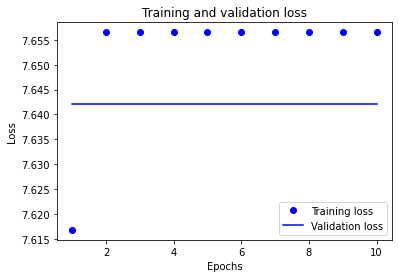

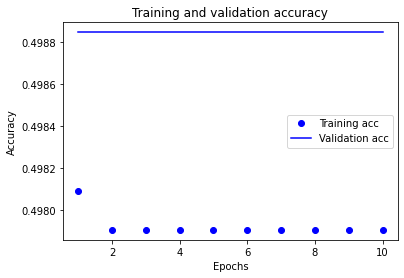

In [21]:
#lstm loss, accuracy 시각화 
visualize_history(history_lstm)

####1-D CNN  
1-D CNN의 경우 epoch수를 증가 시켰을 때 오히려 성능이 떨어지는 걸 확인해서 epoch 수를 적게 설정한 결과를 보면 train은 loss가 감소한데 비해 validation은 loss가 감소하지 않는 것을 확인할 수 있다. 오버피팅이 일어난듯 하다.  
accuracy도 validation은 거의 증가하지 않아 좋은 모델은 아니다.  

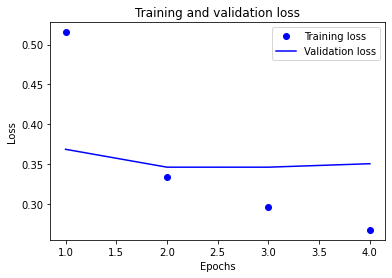

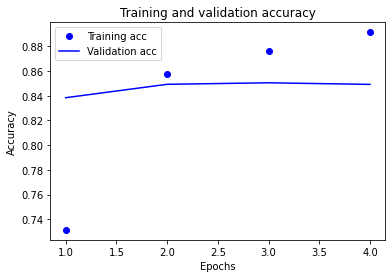

In [22]:
#1-D CNN loss, accuracy 사각화 
visualize_history(history_cnn)

####globalMaxPooling1D  
세 가지 모델 중에서 가장 안정된 형태의 학습이 이뤄졌다.  
성능도 loss: 0.3689 accuracy: 0.8415로 가장 안정된 결과가 나왔다.  

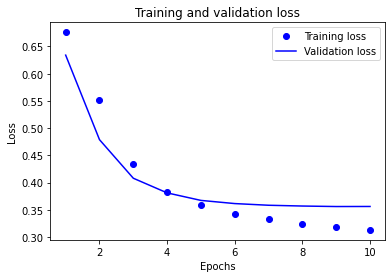

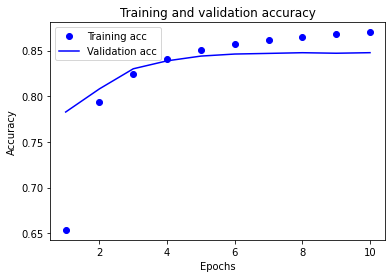

In [23]:
#GlobalMaxPooling1Dloss, accuracy 사각화 
visualize_history(history_gap)

####10. Embedding parameter 파일에 저장  

In [24]:
#학습한 lstm embedding 파라미터를 파일에 써서 저장 
word2vec_lstm_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_lstm.txt'
word2vec_cnn_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_cnn.txt'
word2vec_gap_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_gap.txt'

def embedding_params_save(file_path, model, word_vector_dim, vocab_size): 
    f = open(file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록 
    vectors = model.get_weights()[0]
    for i in range(4,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()

vocab_size = 10000 #어휘 사전 크기
word_vector_dim = 16 

embedding_params_save(word2vec_lstm_file_path, lstm, word_vector_dim, vocab_size)
embedding_params_save(word2vec_cnn_file_path, cnn, word_vector_dim, vocab_size)
embedding_params_save(word2vec_gap_file_path, gap, word_vector_dim, vocab_size)

####11.연관성 있는 단어 예측  

In [25]:
word_vectors_gap = Word2VecKeyedVectors.load_word2vec_format(word2vec_gap_file_path, binary=False)
vector = word_vectors_gap['배우']
print(vector)
word_vectors_gap.similar_by_word("배우") #학습이 잘 안된거 같음  

[ 0.06088009  0.04274062  0.10943528 -0.13309568 -0.04686831 -0.09650271
 -0.05551997 -0.08642636 -0.06591008  0.04608893 -0.11068842  0.09390742
 -0.03878328  0.0078769   0.26710564 -0.12880225]


[('내', 0.9435185194015503),
 ('대사', 0.9252885580062866),
 ('너무', 0.9112926125526428),
 ('도망', 0.9077329635620117),
 ('더', 0.8915201425552368),
 ('나온', 0.8912932276725769),
 ('해서', 0.8890978693962097),
 ('같', 0.884670078754425),
 ('하', 0.8820836544036865),
 ('까지', 0.8755137920379639)]

<b>12.한국어 Word2Vec 임베딩 활용</b>  
단어의 특성을 저차원 벡터값으로 표현할 수 있는 워드 임베딩(word embedding) 기법  
pip install --upgrade gensim==3.8.3 입력해주기  

In [26]:
#한국어 Word2Vec 파일 불러오기 
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
similar_words = word2vec.wv.most_similar("배우")

word2vec = word2vec.wv

similar_words#배우와 연관성이 큰 단어 출력 선보이??

[('가르치', 0.7075916528701782),
 ('익히', 0.5947338938713074),
 ('공부', 0.5693216919898987),
 ('영화배우', 0.523245096206665),
 ('연출가', 0.509418249130249),
 ('후배', 0.49829238653182983),
 ('연극배우', 0.47326865792274475),
 ('연마', 0.4723285734653473),
 ('선보이', 0.471835732460022),
 ('무용가', 0.46976548433303833)]

In [27]:
#embedding layer를 word2vec의 것으로 교체
vocab_size = 10000
word_vector_dim = 200 #parameter를 300으로 바꾸고 싶었으나 오류 발생 
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [28]:
# LSTM
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
lstm.add(keras.layers.LSTM(128))
lstm.add(keras.layers.Dense(128, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 2,185,089
Trainable params: 2,185,089
Non-trainable params: 0
_________________________________________________________________


In [29]:
# 1-D CNN
cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
cnn.add(keras.layers.Dropout(0.3))
cnn.add(keras.layers.Conv1D(512, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Dropout(0.5))
cnn.add(keras.layers.Conv1D(512, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dropout(0.5))
cnn.add(keras.layers.Dense(256, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
dropout (Dropout)            (None, 41, 200)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 512)           717312    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 512)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 512)            1835520   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)              

In [30]:
#GlobalAveragePooling1D layer
gap = keras.Sequential()
gap.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
gap.add(keras.layers.GlobalAveragePooling1D())
gap.add(keras.layers.Dropout(0.5))
gap.add(keras.layers.Dense(8, activation='relu'))
gap.add(keras.layers.Dense(1, activation='sigmoid'))

gap.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 200)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [31]:
epochs = 4
lstm.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_lstm = lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/4
172/172 [==============================] - 4s 17ms/step - loss: 0.5020 - accuracy: 0.7496 - val_loss: 0.4268 - val_accuracy: 0.8020
Epoch 2/4
172/172 [==============================] - 3s 15ms/step - loss: 0.3771 - accuracy: 0.8297 - val_loss: 0.3773 - val_accuracy: 0.8303
Epoch 3/4
172/172 [==============================] - 3s 15ms/step - loss: 0.3246 - accuracy: 0.8589 - val_loss: 0.3458 - val_accuracy: 0.8500
Epoch 4/4
172/172 [==============================] - 3s 15ms/step - loss: 0.2896 - accuracy: 0.8759 - val_loss: 0.3279 - val_accuracy: 0.8593


In [32]:
cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 10

history_cnn = cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
172/172 [==============================] - 10s 49ms/step - loss: 0.6806 - accuracy: 0.6080 - val_loss: 0.5170 - val_accuracy: 0.7528
Epoch 2/10
172/172 [==============================] - 7s 43ms/step - loss: 0.4966 - accuracy: 0.7603 - val_loss: 0.4333 - val_accuracy: 0.8057
Epoch 3/10
172/172 [==============================] - 7s 43ms/step - loss: 0.4310 - accuracy: 0.8031 - val_loss: 0.3956 - val_accuracy: 0.8317
Epoch 4/10
172/172 [==============================] - 7s 42ms/step - loss: 0.3883 - accuracy: 0.8260 - val_loss: 0.3785 - val_accuracy: 0.8420
Epoch 5/10
172/172 [==============================] - 7s 42ms/step - loss: 0.3606 - accuracy: 0.8410 - val_loss: 0.3658 - val_accuracy: 0.8489
Epoch 6/10
172/172 [==============================] - 7s 42ms/step - loss: 0.3393 - accuracy: 0.8519 - val_loss: 0.3570 - val_accuracy: 0.8528
Epoch 7/10
172/172 [==============================] - 7s 42ms/step - loss: 0.3192 - accuracy: 0.8617 - val_loss: 0.3514 - val_accuracy: 0.854

In [33]:
epochs = 20

gap.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_gap = gap.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
172/172 [==============================] - 1s 5ms/step - loss: 0.6870 - accuracy: 0.5421 - val_loss: 0.6554 - val_accuracy: 0.6140
Epoch 2/20
172/172 [==============================] - 1s 4ms/step - loss: 0.6392 - accuracy: 0.6305 - val_loss: 0.5813 - val_accuracy: 0.7504
Epoch 3/20
172/172 [==============================] - 1s 4ms/step - loss: 0.5825 - accuracy: 0.6902 - val_loss: 0.5224 - val_accuracy: 0.7720
Epoch 4/20
172/172 [==============================] - 1s 4ms/step - loss: 0.5364 - accuracy: 0.7312 - val_loss: 0.4856 - val_accuracy: 0.7785
Epoch 5/20
172/172 [==============================] - 1s 4ms/step - loss: 0.5019 - accuracy: 0.7554 - val_loss: 0.4494 - val_accuracy: 0.7980
Epoch 6/20
172/172 [==============================] - 1s 4ms/step - loss: 0.4755 - accuracy: 0.7741 - val_loss: 0.4260 - val_accuracy: 0.8130
Epoch 7/20
172/172 [==============================] - 1s 4ms/step - loss: 0.4551 - accuracy: 0.7867 - val_loss: 0.4112 - val_accuracy: 0.8203
Epoch 

In [34]:
# LSTM
results_lstm = lstm.evaluate(X_test, y_test, verbose=2)
print(results_lstm)

# 1-D CNN
results_cnn = cnn.evaluate(X_test, y_test, verbose=2)
print(results_cnn)

# one GlobalAveragePooling1D layer
results_gap = gap.evaluate(X_test, y_test, verbose=2)
print(results_gap)

1537/1537 - 3s - loss: 0.3353 - accuracy: 0.8548
[0.33532658219337463, 0.8548324704170227]
1537/1537 - 3s - loss: 0.3388 - accuracy: 0.8534
[0.3387944996356964, 0.8534084558486938]
1537/1537 - 2s - loss: 0.3637 - accuracy: 0.8398
[0.36368927359580994, 0.8397583365440369]


####LSTM  
epoch수가 많은 것 보다 적을 때 더 학습이 잘 되는 것 같다.  
train과 validation의 loss가 안정되게 감소하고 accuracy도 안정되게 증가했다.  
최종 성능은 loss: 0.3371 - accuracy: 0.8507로 원하던 성능을 달성했다.  

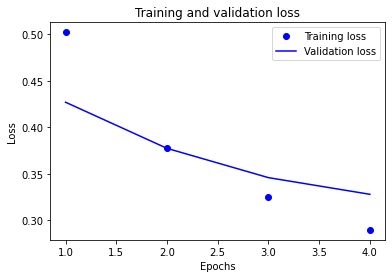

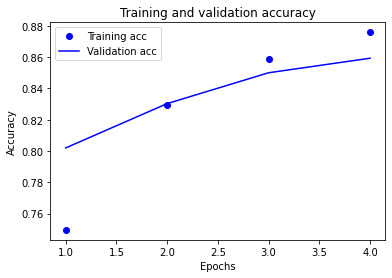

In [35]:
visualize_history(history_lstm)

####1-D CNN  
아이펠에서 제공해준 기본 모델에서 Dropout을 3층 추가했더니 성능이 증가했다.  
Dropout이 오버피팅을 막아주는 역할을 한 것 같다.  
최종 성능은 loss: 0.3384 - accuracy: 0.8519로 목표를 달성했다.  
lstm과 다르게 epoch수가 증가했을 때 성능이 개선되는 것을 확인할 수 있었다.  


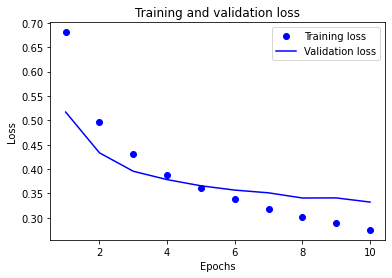

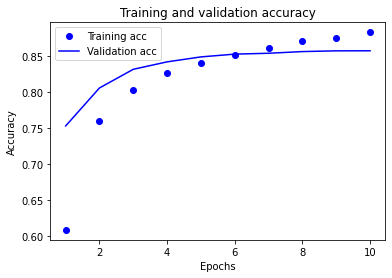

In [36]:
visualize_history(history_cnn)

####globalaveragepooling  
word2Vec임베딩을 활용하면 정확도가 0.85는 금방 넘어갈거라 예상했는데 의외로 0.84에서 변하지 않았다.  
Dense층을 추가하고 Dropout도 적용했는데 개선이 되지 않았고 기본 모델의 정확도가 가장 높았다.  
그래도 그래프 상으로는 loss 감소 정도나 accuracy가 train과 validation 둘 다 비슷한 형태를 보였다.  
최종 성능은 loss: 0.3637 - accuracy: 0.8398이었다.  


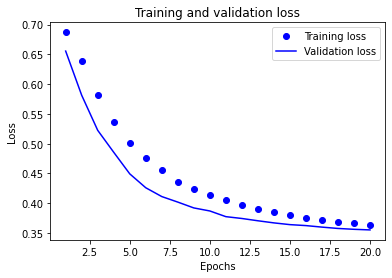

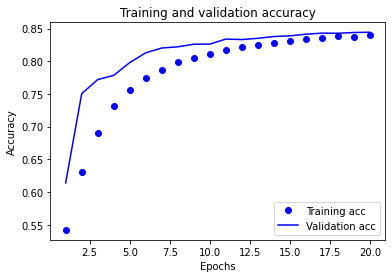

In [37]:
visualize_history(history_gap)

In [44]:
word2vec_ko_gap_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_ko_gap.txt'
word2vec_ko_cnn_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_ko_cnn.txt'
word2vec_ko_lstm_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_ko_lstm.txt'
def embedding_params_save(file_path, model, word_vector_dim, vocab_size): 
    f = open(file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록 
    vectors = model.get_weights()[0]
    for i in range(4,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()

vocab_size = 10000 #어휘 사전 크기
word_vector_dim = 200

embedding_params_save(word2vec_ko_gap_file_path, gap, word_vector_dim, vocab_size)
embedding_params_save(word2vec_ko_cnn_file_path, cnn, word_vector_dim, vocab_size)
embedding_params_save(word2vec_ko_lstm_file_path, lstm, word_vector_dim, vocab_size)

In [46]:
word_vectors_lstm = Word2VecKeyedVectors.load_word2vec_format(word2vec_ko_lstm_file_path, binary=False)
vector = word_vectors_lstm['배우']
#print(vector)
word_vectors_lstm.similar_by_word("배우")

[('가르치', 0.7090420722961426),
 ('공부', 0.5722820162773132),
 ('영화배우', 0.5202804803848267),
 ('연출가', 0.5097790956497192),
 ('후배', 0.5053642392158508),
 ('좋아하', 0.4645058214664459),
 ('읽', 0.4623255133628845),
 ('가수', 0.4579480290412903),
 ('평론가', 0.4576159715652466),
 ('스턴트', 0.45149123668670654)]

In [45]:
word_vectors_cnn = Word2VecKeyedVectors.load_word2vec_format(word2vec_ko_cnn_file_path, binary=False)
vector = word_vectors_cnn['배우']
#print(vector)
word_vectors_cnn.similar_by_word("배우")

[('가르치', 0.7079271078109741),
 ('공부', 0.5695375204086304),
 ('영화배우', 0.5112304091453552),
 ('연출가', 0.49914026260375977),
 ('후배', 0.4930921196937561),
 ('읽', 0.475610613822937),
 ('좋아하', 0.4600546658039093),
 ('가수', 0.44866228103637695),
 ('선배', 0.4448315501213074),
 ('제작자', 0.43851974606513977)]

In [47]:
word_vectors_gap = Word2VecKeyedVectors.load_word2vec_format(word2vec_ko_gap_file_path, binary=False)
vector = word_vectors_gap['배우']
#print(vector)
word_vectors_gap.similar_by_word("배우")

[('가르치', 0.71714848279953),
 ('공부', 0.573783278465271),
 ('후배', 0.5026363730430603),
 ('연출가', 0.5001469850540161),
 ('영화배우', 0.48688653111457825),
 ('읽', 0.47628462314605713),
 ('좋아하', 0.4590790271759033),
 ('여배우', 0.447270005941391),
 ('가수', 0.44425079226493835),
 ('연기자', 0.4411121904850006)]

In [53]:
words = word_vectors_lstm.similar_by_word("범죄")

###Discussion  
모델링 하기전 pretrained된 word2Vec으로 <b>배우</b>라는 단어를 입력했을 때 다음과 같이 연관성 있는 단어들이 결과로 출력됐다. 선보이라는 단어는 검색해도 나오질 않아 해당 단어의 뜻이 무엇일지 궁금하다.  
[('가르치', 0.7075916528701782),  
 ('익히', 0.5947338938713074),  
 ('공부', 0.5693216919898987),  
 ('영화배우', 0.523245096206665),  
 ('연출가', 0.509418249130249),  
 ('후배', 0.49829238653182983),  
 ('연극배우', 0.47326865792274475),  
 ('연마', 0.4723285734653473),  
 ('선보이', 0.471835732460022),  
 ('무용가', 0.46976548433303833)]  
 cnn으로 학습할 결과로 배우를 입력했을 때 위와 비슷한 결과나 나왔고 '읽'은 아마 배우들이 대본을 읽을 때가 많으니까 연관성이 있다는 것 같다. lstm과 cnn은 거의 비슷한 단어를 예측했고 비슷한 정확도를 보였다.  
 [('가르치', 0.7079271078109741),  
 ('공부', 0.5695375204086304),  
 ('영화배우', 0.5112304091453552),  
 ('연출가', 0.49914026260375977),  
 ('후배', 0.4930921196937561),  
 ('읽', 0.475610613822937),  
 ('좋아하', 0.4600546658039093),  
 ('가수', 0.44866228103637695),  
 ('선배', 0.4448315501213074),  
 ('제작자', 0.43851974606513977)]  
 globalaveragepooling의 hyperparameter tuning이 어려웠어서 좀 더 배운다음 다시 시도해봐야겠다.  
 마지막으로 가장 성능이 좋게 나왔던 lstm으로 '범죄'를 입력했더니 꽤 연관성이 높아 보이는 단어들을 예측했다.  
 범죄라는 단어가 특징이 뚜렷해서 납득할 수 있는 단어들이 예측된 것 같다.  
 반면에 중의적 의미가 있거나 모호한 뜻의 단어는 연관성 있는 단어를 정확히 예측하기 어려울 것 같다.  
 [('행위', 0.6702514886856079),  
 ('범죄자', 0.6494574546813965),  
 ('강간', 0.5745567083358765),  
 ('처벌', 0.5708119869232178),  
 ('착오', 0.569055438041687),  
 ('폭력', 0.5344015955924988),  
 ('테러', 0.5333479642868042),  
 ('피해자', 0.5302156209945679),  
 ('살인', 0.524613618850708),  
 ('가해자', 0.5239765644073486)]  
   
   
 
 